# Homework 2: Predicting Housing Prices

In [591]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import os
from subprocess import call, check_output
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew,norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt


#call(['unzip','all.zip'])

os.listdir()

['test.csv.gz',
 'sample_submission.csv.gz',
 'test.csv',
 'data_description.txt',
 'all.zip',
 'trial_submission.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'hw2.ipynb',
 'train.csv.gz',
 'sample_submission.csv']

## Data Cleaning

I'm going to read in both train and test and combine them for cleaning purposes.

In [583]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
houses = pd.concat([train, test])

Here are some quick and messy looks at our data. This gives us an initial sense of the values in the data.

In [584]:
houses.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Before we continue describing the data, we should drop Id before we forget and accidentally use it for prediction.

In [585]:
houses.drop(['Id'], axis=1, inplace=True)
houses.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2917.000000,2918.000000,2919.000000,...,2919.000000,2919.000000,1460.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.423235,49.582248,0.429894,0.061364,560.772104,23.098321,...,6.089072,2.251799,180921.195890,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474,2007.792737
std,392.362079,428.701456,25.188169,0.822693,455.610826,169.205611,0.524736,0.245687,439.543659,64.244246,...,1.409947,35.663946,79442.502883,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344,1.314964
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,5.000000,0.000000,129975.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.500000,0.000000,0.000000,0.000000,467.000000,0.000000,...,6.000000,0.000000,163000.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.500000,0.000000,...,7.000000,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,10.000000,800.000000,755000.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [550]:
houses.corr()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1stFlrSF,1.000000,-0.249823,0.044086,0.108418,0.458206,0.084389,0.257950,0.010462,0.296788,-0.065796,...,0.479152,0.121900,0.596981,0.098381,0.391782,0.801376,0.227347,0.310814,0.242245,-0.013442
2ndFlrSF,-0.249823,1.000000,-0.032458,0.503506,-0.161997,-0.097654,-0.160956,-0.060133,-0.000032,0.054645,...,0.245596,0.044503,0.319300,0.011070,0.584586,-0.204802,0.089922,0.017588,0.158985,-0.019229
3SsnPorch,0.044086,-0.032458,1.000000,-0.048279,0.050934,-0.023268,0.027429,0.026878,-0.005764,-0.032822,...,0.018715,-0.006525,0.054900,-0.029546,-0.025764,0.037940,-0.003935,0.015958,0.037433,0.022560
BedroomAbvGr,0.108418,0.503506,-0.048279,1.000000,-0.113161,-0.031111,-0.155392,0.018689,0.183631,0.049940,...,0.073075,0.036544,0.209044,0.007254,0.669737,0.054185,0.031644,-0.053101,-0.021912,-0.020453
BsmtFinSF1,0.458206,-0.161997,0.050934,-0.113161,1.000000,-0.054938,0.639038,0.078500,-0.476771,-0.099575,...,0.282150,0.084470,0.372023,0.096901,0.052629,0.536650,0.223681,0.279780,0.152576,0.022500
BsmtFinSF2,0.084389,-0.097654,-0.023268,-0.031111,-0.054938,1.000000,0.162957,0.099530,-0.238043,0.032775,...,-0.042605,0.044530,0.004832,0.063329,-0.048245,0.089561,0.098462,-0.027507,-0.061959,0.008867
BsmtFullBath,0.257950,-0.160956,0.027429,-0.155392,0.639038,0.162957,1.000000,-0.148655,-0.397648,-0.068172,...,0.165060,0.043996,0.236224,0.053265,-0.039210,0.326252,0.186445,0.211849,0.135150,0.045155
BsmtHalfBath,0.010462,-0.060133,0.026878,0.018689,0.078500,0.099530,-0.148655,1.000000,-0.106840,-0.009613,...,-0.040519,0.066860,-0.005149,0.042115,-0.049631,0.012780,0.051665,-0.030171,-0.046167,-0.020055
BsmtUnfSF,0.296788,-0.000032,-0.005764,0.183631,-0.476771,-0.238043,-0.397648,-0.106840,1.000000,0.005162,...,0.275643,-0.032236,0.221985,-0.049019,0.248015,0.412810,-0.038964,0.130786,0.165770,-0.038073
EnclosedPorch,-0.065796,0.054645,-0.032822,0.049940,-0.099575,0.032775,-0.068172,-0.009613,0.005162,1.000000,...,-0.139256,0.092534,-0.149050,-0.064377,0.015345,-0.085131,-0.119114,-0.374073,-0.220456,-0.001134


In [551]:
houses.corr().SalePrice.sort_values()

EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.054900
MoSold           0.057329
PoolArea         0.069798
ScreenPorch      0.121208
BedroomAbvGr     0.209044
BsmtUnfSF        0.221985
BsmtFullBath     0.236224
LotArea          0.257320
HalfBath         0.313982
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355878
BsmtFinSF1       0.372023
MasVnrArea       0.426775
Fireplaces       0.489449
TotRmsAbvGrd     0.534422
GarageYrBlt      0.541073
YearRemodAdd     0.565608
YearBuilt        0.586570
FullBath         0.594771
1stFlrSF         0.596981
TotalBsmtSF      0.612134
GarageArea       0.650888
GarageCars       0.680625
GrLivArea        0.700927
OverallQual      0.817184
SalePrice        1.000000
Name: SalePrice, dtype: float64

### Missing Values

We're first going to see which values are missing.

In [586]:
print('observations', houses.shape[0], '\n')

def missing_values(df):
    #Print out missing values sorted from high to low.
    missingDict = {}
    for var in df.columns:
        missingDict[var] = df[df[var].isnull()].shape[0]

    return pd.Series(missingDict).sort_values(ascending=False)

missing_values(houses)

observations 2919 



PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageCond        159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
Electrical          1
Exterior2nd         1
KitchenQual         1
GarageCars          1
Exterior1st         1
GarageArea          1
                 ... 
GrLivArea           0
YearRemodAdd        0
YearBuilt           0
WoodDeckSF          0
TotRmsAbvGrd        0
Street              0
ScreenPorch         0
SaleCondition       0
RoofStyle           0
RoofMatl            0
PoolArea            0
PavedDrive          0
OverallQual         0
OverallCond         0
OpenPorchS

There are quite a few missing values. Luckily, data_description.txt states what some of those values should be. The missing SalePrice is from the test set, so we can ignore that for cleaning. For some numeric types, they are missing because that room or element of the house does not exist, so we'll set the numeric type to zero. Finally, there are some missing values that we will change to other.

In [588]:
def clean_NA(df, varList, replacementValue):
    for var in varList:
        df.loc[houses[var].isnull(),var] = replacementValue
    return 0

changeToNone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',\
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType',\
                'GarageYrBlt', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Electrical']
changeToZero = ['GarageCars', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  \
                'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath']
changeToOth = ['SaleType', 'Exterior1st', 'Exterior2nd']
varLists = [changeToNone, changeToZero, changeToOth]
replacementValues = ['None', 0, 'Oth']
for params in zip(varLists, replacementValues):
    clean_NA(houses, params[0], params[1])

missing_values(houses)


#TODO should GarageYrBlt be 0 if it's a year?
#Not included: Electrical, KitchenQual, Functional, Utilities, MSZoning
#Need to still work out: LotFrontage, SalePrice

SalePrice        1459
LotFrontage       486
Foundation          0
ExterCond           0
ExterQual           0
Exterior1st         0
Exterior2nd         0
Fence               0
FireplaceQu         0
Fireplaces          0
YrSold              0
Electrical          0
FullBath            0
Functional          0
GarageArea          0
GarageCars          0
GarageCond          0
GarageFinish        0
GarageQual          0
GarageType          0
EnclosedPorch       0
Condition2          0
GrLivArea           0
BsmtFinSF1          0
2ndFlrSF            0
3SsnPorch           0
Alley               0
BedroomAbvGr        0
BldgType            0
BsmtCond            0
                 ... 
RoofStyle           0
SaleType            0
Heating             0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         0
Utilities           0
WoodDeckSF          0
YearBuilt           0
OpenPorchSF         0
Neighborhood        0
MoSold              0
MiscVal             0
HeatingQC 

We also need to change LotFrontage, but the documentation has no clue as to why this is missing. We'll impute it after fixing a couple other things. Next, let's look at the sale price and compare it to a norm distribution.

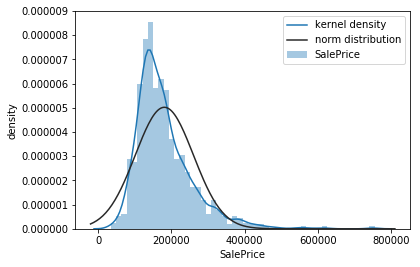

In [601]:
def distplot(var):
    sns.distplot(houses.loc[~houses[var].isnull(),var], bins=50, fit=norm, axlabel=var, label=var, fit_kws={'label': 'norm distribution'}, kde_kws={'label': 'kernel density'})
    plt.ylabel('density')
    plt.legend()

distplot('SalePrice')

This is quite skewed even without checkiing the skew. Let's take the log and see if it fixes it.

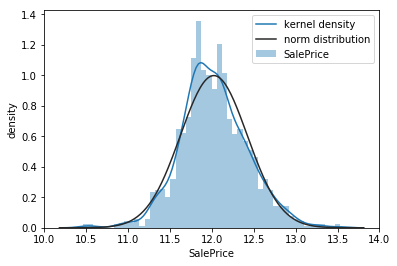

In [602]:
houses.SalePrice = np.log(houses.SalePrice)
distplot('SalePrice')

Beautiful! Not perfect, but much better than before.

After noting that the sale price is skewed, I'm going to fix the other numeric variables for skewness. I noticed quite a few kernels using box cox, so I follow a lot of their queues. I define dummy variables so we don't accidentally change those values.

In [607]:
dummy_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',\
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',\
              'OverallQual', 'OverallCond', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',\
              'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',\
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',\
              'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',\
              'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
numeric_feats = list(set(houses.columns) - set(dummy_list))
# Check the skew of all numerical features
#skewed_feats = houses[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = houses[numeric_feats].skew(axis=0).sort_values()
skewness

YearRemodAdd     -0.451252
GarageCars       -0.219694
SalePrice         0.121335
FullBath          0.167692
GarageArea        0.239380
BedroomAbvGr      0.326492
BsmtFullBath      0.625153
HalfBath          0.694924
Fireplaces        0.733872
TotRmsAbvGrd      0.758757
2ndFlrSF          0.862118
BsmtUnfSF         0.919812
TotalBsmtSF       1.157489
GrLivArea         1.270010
BsmtFinSF1        1.425963
1stFlrSF          1.470360
LotFrontage       1.503278
WoodDeckSF        1.843380
OpenPorchSF       2.536417
MasVnrArea        2.614936
BsmtHalfBath      3.933616
ScreenPorch       3.948723
EnclosedPorch     4.005950
BsmtFinSF2        4.148275
KitchenAbvGr      4.304467
3SsnPorch        11.381914
LowQualFinSF     12.094977
LotArea          12.829025
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

I'm not extremely familiar with Box Cox, so I used the kernel's hyper parameters.

In [608]:
from scipy.special import boxcox1p
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    if feat not 'SalePrice':
        houses[feat] = boxcox1p(houses[feat], lam)

There are 21 skewed numerical features to Box Cox transform


Now I'm going to do the last transformations of variables. This includes changing year remodel to years since remodel; scaling data; and creating dummies. I'm also creating a house age at sale variable because both the age of the house and the year it is sold are different dimensions.

In [554]:
#New variables
houses.YearRemodAdd = houses.YrSold - houses.YearRemodAdd
houses.AgeAtSale = houses.YrSold - houses.YearBuilt

#scale data
tmp_list = dummy_list.copy()
tmp_list.extend(['LotFrontage', 'SalePrice']) #FIXME: remember to scale LotFrontage after prediction.
standard = StandardScaler()
tmp = houses.drop(tmp_list, axis=1)
houses.reset_index(drop=True, inplace=True)
houses_standard = pd.DataFrame(standard.fit_transform(tmp), columns=tmp.columns)
houses_standard = pd.concat([houses_standard, houses[tmp_list]], axis=1)

def create_dummies(columnName, df):
    dummy_temp = pd.get_dummies(df[columnName])
    dummy_temp.columns = [columnName + '_' + str(i) for i in dummy_temp.columns]
    df = pd.concat([df, dummy_temp], axis=1)
    df.drop([columnName], axis=1, inplace=True)
    return df

for var in dummy_list:
    houses_standard = create_dummies(var, houses_standard)

Now we return to the last missing variable, lot frontage. Lot frontage is the feet of street connected to property. I saw many kernels fill this with the median, but I think that K nearest neighbors is a better method. To reduce dimensionality, we're going to select variables that either have high correlations or intuitively influence street close to the property.

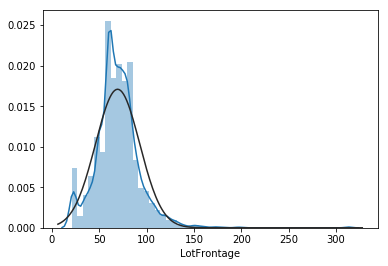

In [558]:
sns.distplot(houses_standard.loc[~houses_standard['LotFrontage'].isnull(), 'LotFrontage'], fit=norm)

In [561]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

neededValues = houses_standard.loc[houses_standard['LotFrontage'].isnull(),['1stFlrSF', 'LotConfig_Inside', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'Street_Grvl', 'Street_Pave']]
target = houses_standard.loc[~houses_standard['LotFrontage'].isnull(),'LotFrontage']
X = houses_standard.loc[~houses_standard['LotFrontage'].isnull(),['1stFlrSF', 'LotConfig_Inside', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'Street_Grvl', 'Street_Pave']]
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, random_state=42)
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train)),
                                           np.sqrt(mean_squared_error(y_test, y_pred_test))))


Best Params: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Train MSE: 17.836830641366372	Test MSE: 20.85947192993592


The MSE's are okay, maybe with a little of overfitting. It's not too concerning since this is not the variable that we are primarily interested in.

In [563]:
predValues = gridsearch.predict(neededValues)
houses_standard.loc[houses_standard.LotFrontage.isnull(),'LotFrontage'] = predValues

Now I need to scale lot frontage since I skipped it earlier due to the missing values.

In [611]:
standard = StandardScaler()
LotFrontage = standard.fit_transform(houses_standard.LotFrontage.values.reshape(-1,1))
houses_standard.drop(['LotFrontage'], axis=1, inplace=True)
houses_standard['LotFrontage'] = LotFrontage

### Fix Outliers

To identify outliers, we're going to look at the variable with the highest correlation with SalePrice, GrLivArea. This will show us some of the abnormal values.

In [489]:
train = houses_standard.loc[~houses_standard.SalePrice.isnull(), :]
test  = houses_standard.loc[houses_standard.SalePrice.isnull(), :]

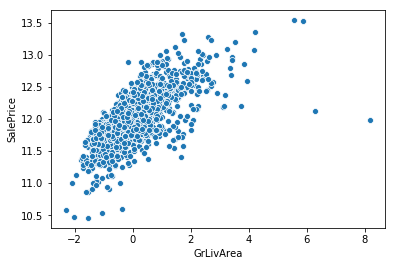

In [490]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)

In [491]:
train = train.loc[train['GrLivArea'] < 5, :]

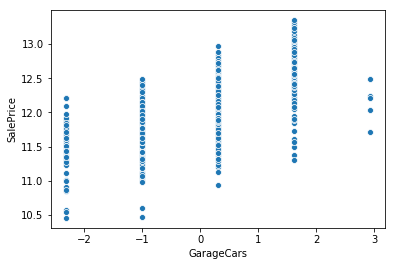

In [492]:
#TODO what should I do about four garage cars?
sns.scatterplot(x='GarageCars', y='SalePrice', data=train)

In [493]:
#train = train.loc[train['GarageCars'] < 2, :]

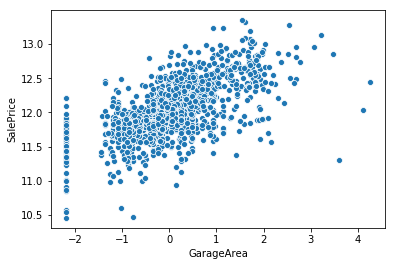

In [494]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train)

In [495]:
train.loc[train['GarageArea'] > 3, ['SalePrice', 'GarageArea']]

,SalePrice,GarageArea
178,13.126031,3.217129
581,12.442302,4.256579
664,12.955127,3.068637
825,12.860999,3.467711
1061,11.302204,3.597642
1190,12.031719,4.098805


In [496]:
#train.drop([1061, 581], inplace=True)

Most negative correlation variables are dummies, so we're not going to investigate those.

In [497]:
#TODO examine whether these are outliers.
train.loc[train['SalePrice'] < -3, :]

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


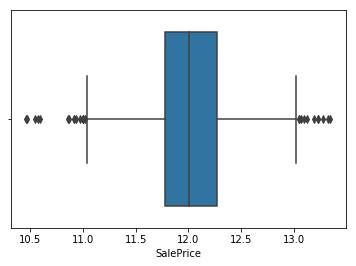

In [498]:
sns.boxplot(train.SalePrice)

In [499]:
#train = train.loc[train['SalePrice'] >= -10.5, :]

In [500]:
missing_values(train)

YrSold_2010             0
GarageYrBlt_1931.0      0
GarageYrBlt_1937.0      0
GarageYrBlt_1936.0      0
GarageYrBlt_1935.0      0
GarageYrBlt_1934.0      0
GarageYrBlt_1933.0      0
GarageYrBlt_1932.0      0
GarageYrBlt_1930.0      0
GarageYrBlt_1939.0      0
GarageYrBlt_1929.0      0
GarageYrBlt_1928.0      0
GarageYrBlt_1927.0      0
GarageYrBlt_1926.0      0
GarageYrBlt_1925.0      0
GarageYrBlt_1924.0      0
GarageYrBlt_1938.0      0
GarageYrBlt_1940.0      0
GarageYrBlt_1922.0      0
GarageYrBlt_1950.0      0
GarageYrBlt_1956.0      0
GarageYrBlt_1955.0      0
GarageYrBlt_1954.0      0
GarageYrBlt_1953.0      0
GarageYrBlt_1952.0      0
GarageYrBlt_1951.0      0
GarageYrBlt_1949.0      0
GarageYrBlt_1941.0      0
GarageYrBlt_1948.0      0
GarageYrBlt_1947.0      0
                       ..
Neighborhood_NWAmes     0
Neighborhood_NPkVill    0
Neighborhood_NAmes      0
Neighborhood_Mitchel    0
Neighborhood_IDOTRR     0
OverallCond_9           0
Neighborhood_Gilbert    0
Neighborhood

## Models

### Simple Gradient Descent

In [501]:
#Train test split
SalePrice = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train, SalePrice, test_size=0.2)

In [502]:
model = SGDRegressor(tol=0.0001, eta0=0.01)
model.fit(Xtrain, Ytrain)
trainPred = model.predict(Xtrain)
testPred = model.predict(Xtest)

trainMSE = mean_squared_error(Ytrain, trainPred)
testMSE  = mean_squared_error(Ytest, testPred)

print("Train MSE: {}".format(trainMSE))
print("Test MSE: {}".format(testMSE))

Train MSE: 3.0032680120266263e+24
Test MSE: 2.9329147576304883e+24


## Elastic Net

In [503]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(Xtrain, Ytrain)
train_predictions = clf.predict(Xtrain)
test_predictions = clf.predict(Xtest)
print("Train MSE: {}".format(mean_squared_error(Ytrain, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(Ytest, test_predictions)))

Train MSE: 0.02329379931832473
Test MSE: 0.02258066893563379


In [504]:
test.drop(['SalePrice'], inplace=True, axis=1)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [505]:
scores = clf.predict(test)

In [506]:
ids = pd.read_csv('test.csv', usecols=['Id'])

In [507]:
ids.head()

,Id
0,1461
1,1462
2,1463
3,1464
4,1465


In [508]:
scores = pd.concat([ids, pd.Series(scores)], axis=1)

In [509]:
scores.head()

,Id,0
0,1461,11.681799
1,1462,11.883664
2,1463,12.176380
3,1464,12.209353
4,1465,12.007451


In [510]:
scores.columns = ['Id', 'SalePrice']

In [511]:
scores.head()

,Id,SalePrice
0,1461,11.681799
1,1462,11.883664
2,1463,12.176380
3,1464,12.209353
4,1465,12.007451


In [512]:
scores['SalePriceTransformed'] = np.exp(scores.SalePrice)

In [513]:
scores.drop(['SalePrice'], axis=1, inplace=True)

In [514]:
scores.to_csv('trial_submission.csv', index=None)

### K nearest neighbors